# 階層ベイズ atmaCup#15

## 概要

* ユーザーの作品に対するスコアが以下のように2項分布に従うとモデリングする
* scoreは1から10なので、`score - 1` が観測値でるとする

$$
\text{Score} \sim \text{Binom}(n=9, p=p) \\
p = \exp(\beta + r_{user} + r_{anime}) \\

\beta \sim \mathcal{N}(\text{mu}=0, \text{sigma}=100000) \\
r_{user} \sim \mathcal{N}(\text{mu}=0, \text{sigma}=s_{user}) \\
r_{anime} \sim \mathcal{N}(\text{mu}=0, \text{sigma}=s_{anime}) \\

s_{user} \sim \text{Uniform}(\text{lower}=0, \text{upper}=1000) \\
s_{anime} \sim \text{Uniform}(\text{lower}=0, \text{upper}=1000)
$$

## 分かったこと

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
pl.Config.set_tbl_cols(999)
pl.Config.set_tbl_rows(30)

# plt.style.use("ggplot")
sns.set()
plt.rcParams["font.family"] = ["Noto Sans JP"]
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["font.size"] = 10.5

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import os

INPUT_DIR = "../data/"
OUTPUT_DIR = "../output"

In [3]:
df_anime = pd.read_csv(os.path.join(INPUT_DIR, "anime.csv"))
df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))

## データ整備

In [4]:
def hook_user(df_train, df_test):
    df_user = pd.DataFrame({"user_id": pd.concat([df_train, df_test]).user_id.unique()})
    df_train_agg = (
        df_train.groupby("user_id")
        .agg(mean_score=("score", "mean"), train_anime_num=("anime_id", "nunique"))
        .reset_index()
    )
    df_test_agg = (
        df_test.groupby("user_id")
        .agg(test_anime_num=("anime_id", "nunique"))
        .reset_index()
    )

    df_user = df_user.merge(df_train_agg, on="user_id", how="left").merge(
        df_test_agg, on="user_id", how="left"
    )
    return df_user


df_user = hook_user(df_train, df_test)
df_user

,user_id,mean_score,train_anime_num,test_anime_num
0,0008e10fb39e55447333,6.951220,41.0,27.0
1,001a7aed2546342e2602,7.512500,160.0,122.0
2,003d4b0257cc7849ffe1,8.000000,35.0,24.0
3,0054e700b5be6e074fb7,8.166667,6.0,5.0
4,0059344eed7e8ca0b6c5,7.600000,10.0,7.0
...,...,...,...,...
1993,fa11453a6cca09c82953,NaN,NaN,29.0
1994,fa532dafc50ad8439e1d,NaN,NaN,448.0
1995,fcf79144bf18fdb90aa5,NaN,NaN,51.0
1996,fd64597be5e54f4ac9d3,NaN,NaN,1.0


In [5]:
def hook_anime(df_anime, df_train, df_test):
    df_train_agg = (
        df_train.groupby("anime_id")
        .agg(mean_score=("score", "mean"), train_user_num=("user_id", "nunique"))
        .reset_index()
    )
    df_test_agg = (
        df_test.groupby("anime_id")
        .agg(test_user_num=("user_id", "nunique"))
        .reset_index()
    )

    df_anime = df_anime.merge(df_train_agg, on="anime_id", how="left").merge(
        df_test_agg, on="anime_id", how="left"
    )
    # 期間をはじめと終わりの2つのカラムに分割
    df_anime = df_anime.join(
        df_anime["aired"]
        .str.split(" to ", expand=True)
        .rename(columns={0: "start", 1: "end"})
        .replace({"Unknown": None, "?": None})
        .assign(
            start=lambda df: pd.to_datetime(df["start"]),
            end=lambda df: pd.to_datetime(df["end"]),
        )
    )
    # genresを分割して縦持ちに(UNNEST CORSS JOIN)
    df_anime = df_anime.drop(columns=["genres"]).join(
        df_anime["genres"].str.split(",").explode()
    )
    return df_anime


df_summary = hook_anime(df_anime, df_train, df_test)

## 事前調査

* そもそもscoreを2項分布でモデリングすることの妥当性はあるのか？
* スコアの分布を可視化してみる

以下の結果をみると、2項分布の理論値とそこまで大きな差分はなさそう。ただ、最高得点は理論値より結構大きい。

<Axes: xlabel='score', ylabel='Probability'>

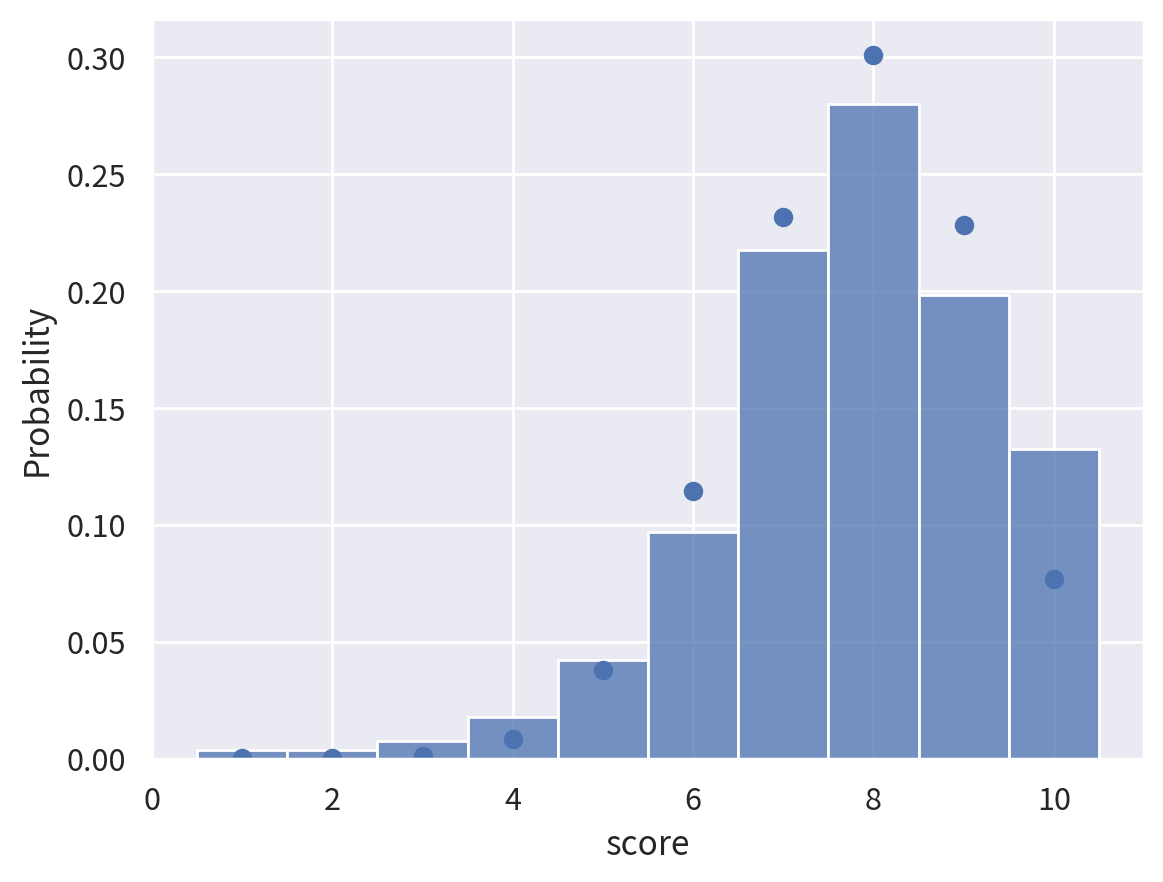

In [20]:
import scipy.stats as st

fig, ax = plt.subplots()

k = np.arange(10)
p = (df_train.score - 1).mean() / 9
binom_pmf = st.binom.pmf(k=k, n=9, p=p)

ax.plot(k + 1, binom_pmf, "o")
sns.histplot(x=df_train.score, stat="probability", discrete=True, ax=ax)

---
## CVによるモデル評価

In [11]:
X = df_train[["user_id", "anime_id"]].values
X_test = df_test[["user_id", "anime_id"]].values
y = df_train["score"].values

In [8]:
# np.arrayから最頻値を計算する関数
def arr_mode(arr: np.ndarray) -> int:
    unique, freq = np.unique(arr, return_counts=True)
    mode = unique[np.argmax(freq)]
    return mode


# 行ごとに、最頻値を計算する関数
arr_modes = lambda x: np.apply_along_axis(arr_mode, axis=1, arr=x)

In [9]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpyro

numpyro.set_platform("cpu")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


user_encoder = LabelEncoder().fit(df_user["user_id"])
anime_encoder = LabelEncoder().fit(df_summary["anime_id"])


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5


def model_factory(X, y):
    x_user = user_encoder.transform(X[:, 0])
    x_anime = anime_encoder.transform(X[:, 1])
    with pm.Model(
        coords={
            "user": user_encoder.transform(user_encoder.classes_),
            "anime": anime_encoder.transform(anime_encoder.classes_),
            "size": np.arange(len(X)),
        }
    ) as model:
        s_user = pm.Uniform("s_user", upper=10**4, lower=0)
        u_user = pm.Normal("u_user", mu=0, sigma=s_user, dims="user")

        s_anime = pm.Uniform("s_anime", upper=10**4, lower=0)
        u_anime = pm.Normal("u_anime", mu=0, sigma=s_anime, dims="anime")

        beta = pm.Normal("beta", mu=0, sigma=10e5)

        y = pm.Binomial(
            "y_obs",
            n=9,
            logit_p=beta + u_user[x_user] + u_anime[x_anime],
            observed=y - 1,
        )
    return model

In [24]:
from sklearn.model_selection import StratifiedKFold


fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split = fold.split(X, y)
idatas = []
preds = []

for i, (train_ind, val_ind) in enumerate(split):
    x_train, y_train = X[train_ind], y[train_ind]
    x_valid, y_valid = X[val_ind], y[val_ind]

    with model_factory(x_train, y_train):
        idata = pm.sample(
            1000, tune=500, return_inferencedata=True, nuts_sampler="numpyro"
        )
    idatas.append(idata)

    with model_factory(x_valid, y_valid):
        pred = pm.sample_posterior_predictive(idata, var_names=["y_obs"])
    y_pred = pred.posterior_predictive["y_obs"].values.reshape(4000, -1).T
    preds.append(y_pred)

    pred_modes = arr_modes(y_pred)
    score = rmse(y_valid, pred_modes)
    print(f"===== FOLD {i + 1}: RMSE={score:.4f} ======")

/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:01.645419
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_obs]


Sampling time =  0:04:53.205867
Transforming variables...
Transformation time =  0:00:00.026852


===== FOLD 1: RMSE=1.4294 ======


/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:01.546589
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_obs]


Sampling time =  0:05:49.497125
Transforming variables...
Transformation time =  0:00:00.028405


===== FOLD 2: RMSE=1.4281 ======


/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:01.893854
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_obs]


Sampling time =  0:05:11.490020
Transforming variables...
Transformation time =  0:00:00.034013


===== FOLD 3: RMSE=1.4289 ======


/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:01.760645
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_obs]


Sampling time =  0:05:16.838597
Transforming variables...
Transformation time =  0:00:00.031592


===== FOLD 4: RMSE=1.4302 ======


/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:02.199906
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_obs]


Sampling time =  0:06:33.127914
Transforming variables...
Transformation time =  0:00:00.039320


===== FOLD 5: RMSE=1.4209 ======


## 全データを使って、提出用モデルを作成

In [12]:
with model_factory(X, y):
    idata = pm.sample(1000, tune=500, return_inferencedata=True, nuts_sampler="numpyro")

/home/kazu/.virtualenvs/ds/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning:

Use of external NUTS sampler is still experimental



Compiling...
Compilation time =  0:00:01.927983
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:06:23.108695
Transforming variables...
Transformation time =  0:00:00.052863


In [13]:
with model_factory(X_test, np.ones(len(X_test))):
    pred_test = pm.sample_posterior_predictive(idata, var_names=["y_obs"])

Sampling: [y_obs]


In [14]:
y_test_pred = pred_test.posterior_predictive["y_obs"].values.reshape(4000, -1).T
y_test_pred_mode = arr_modes(y_test_pred)
# pd.DataFrame({"score": y_test_pred_mode + 1}).to_csv(
#     "../output/submission_#1_bayse_baseline.csv", index=False
# )

---
## 統計モデリングの結果を解釈

In [28]:
with model_factory(X, y):
    pred_train = pm.sample_posterior_predictive(idata, var_names=["y_obs"])

Sampling: [y_obs]


In [30]:
y_train_pred = pred_train.posterior_predictive["y_obs"].values.reshape(4000, -1).T
y_train_pred.shape

(136401, 4000)

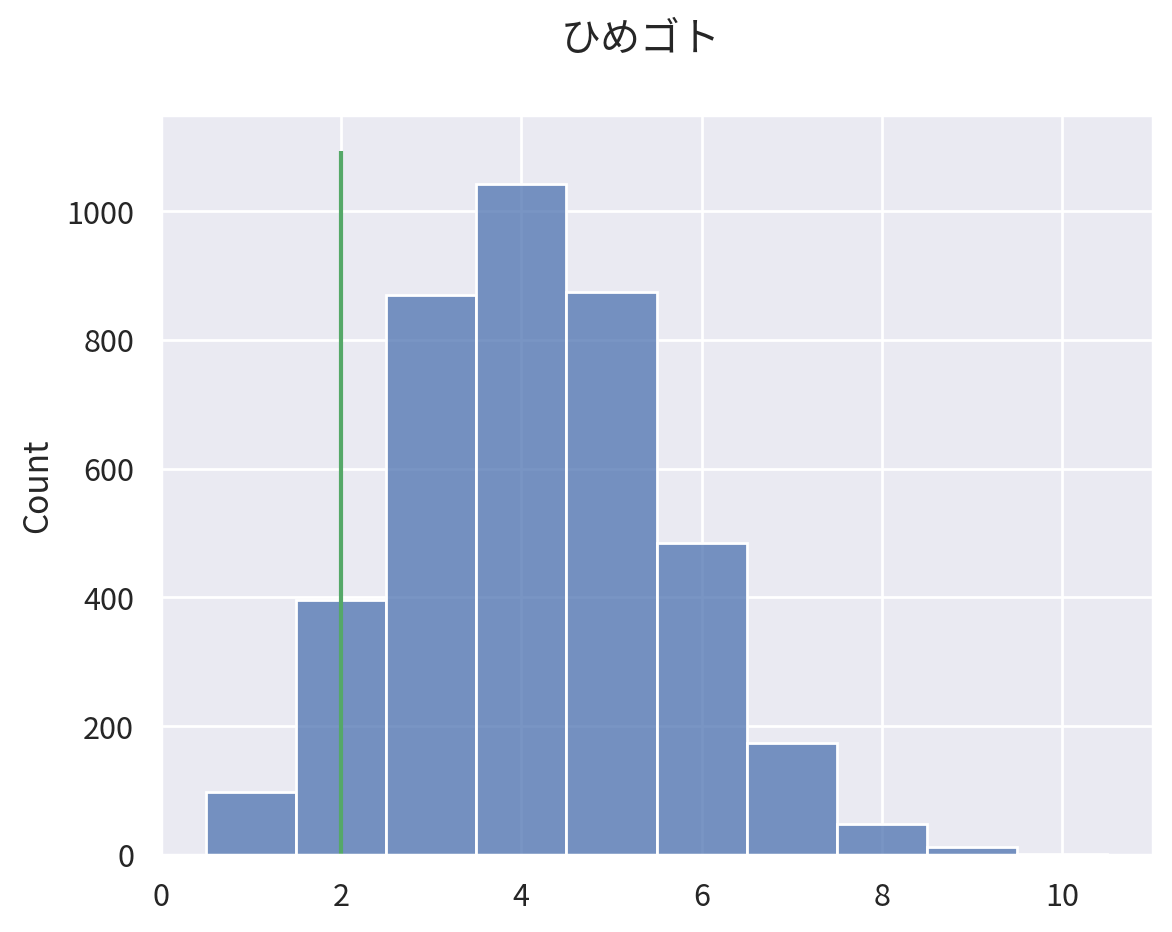

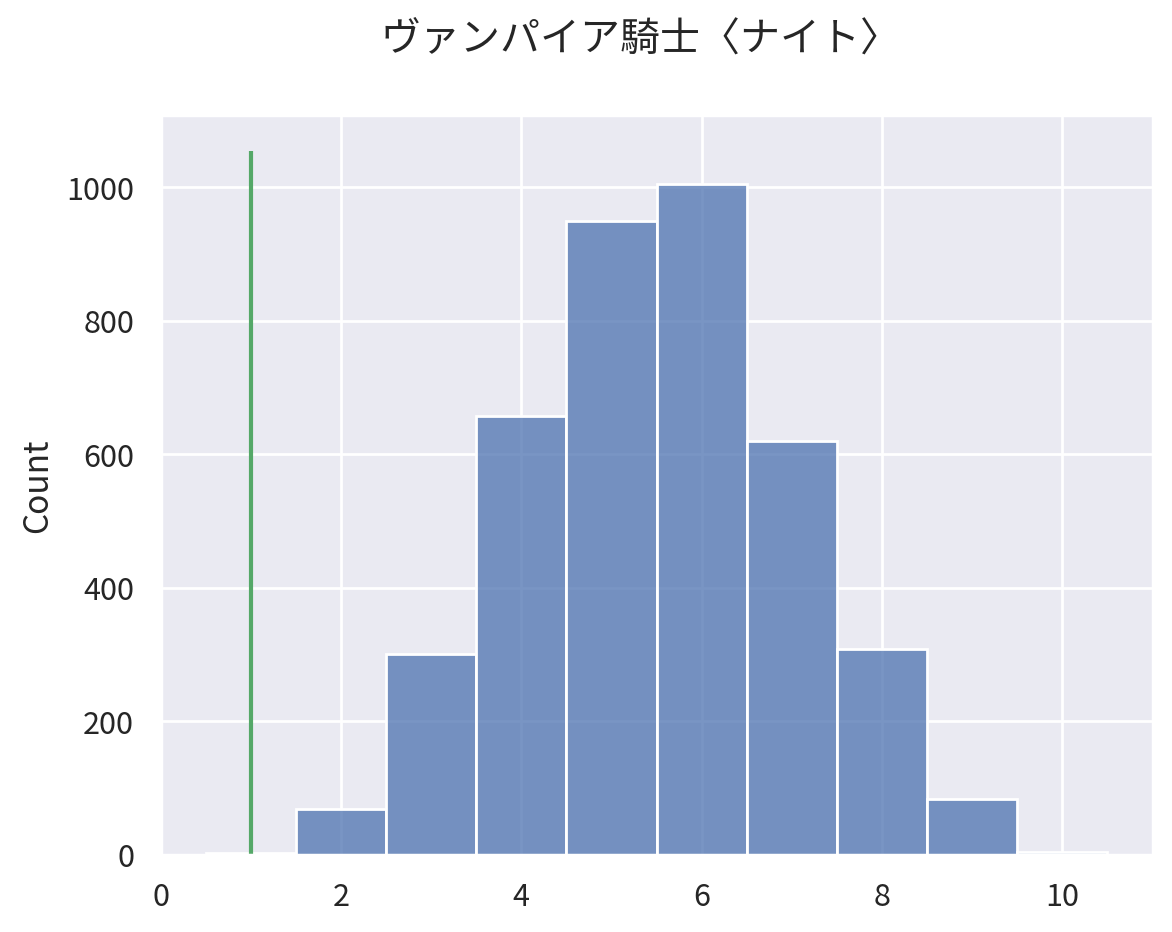

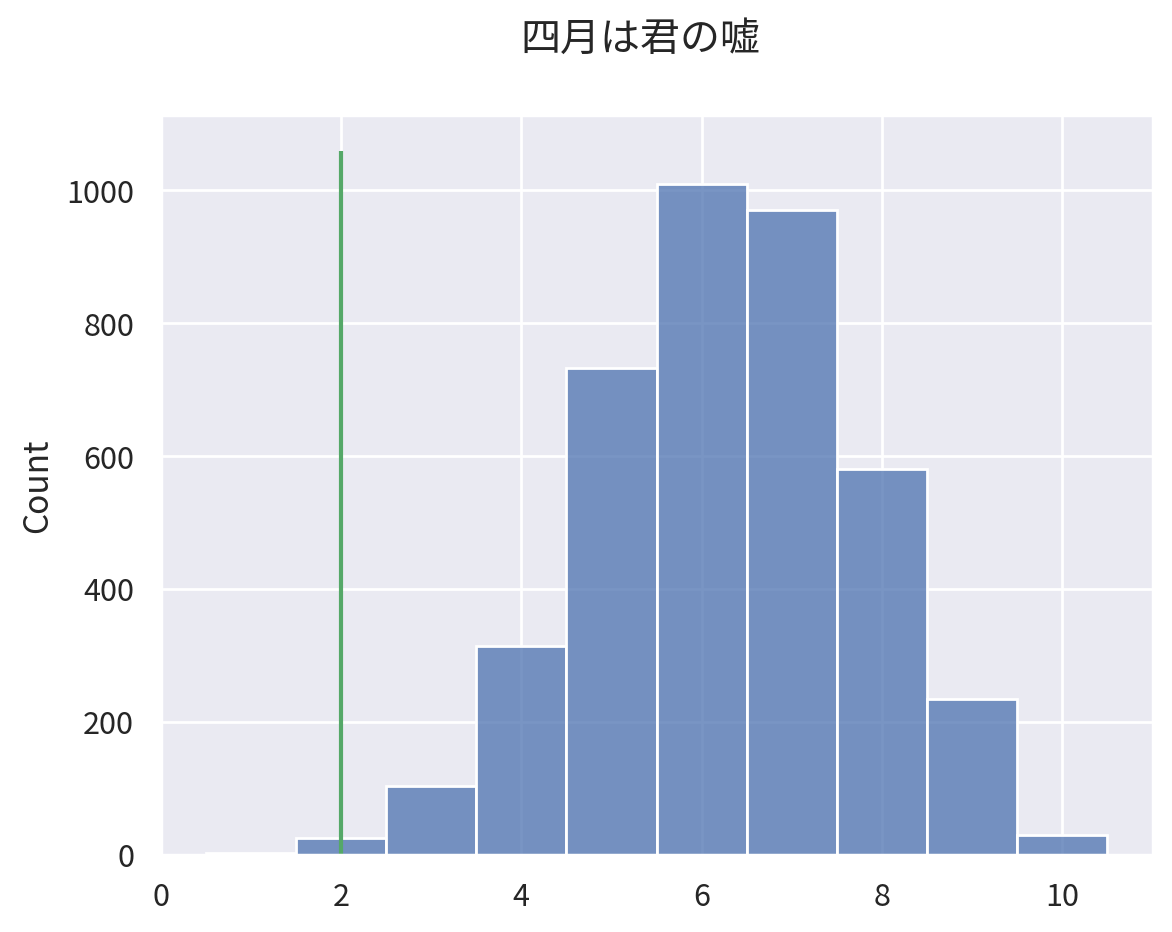

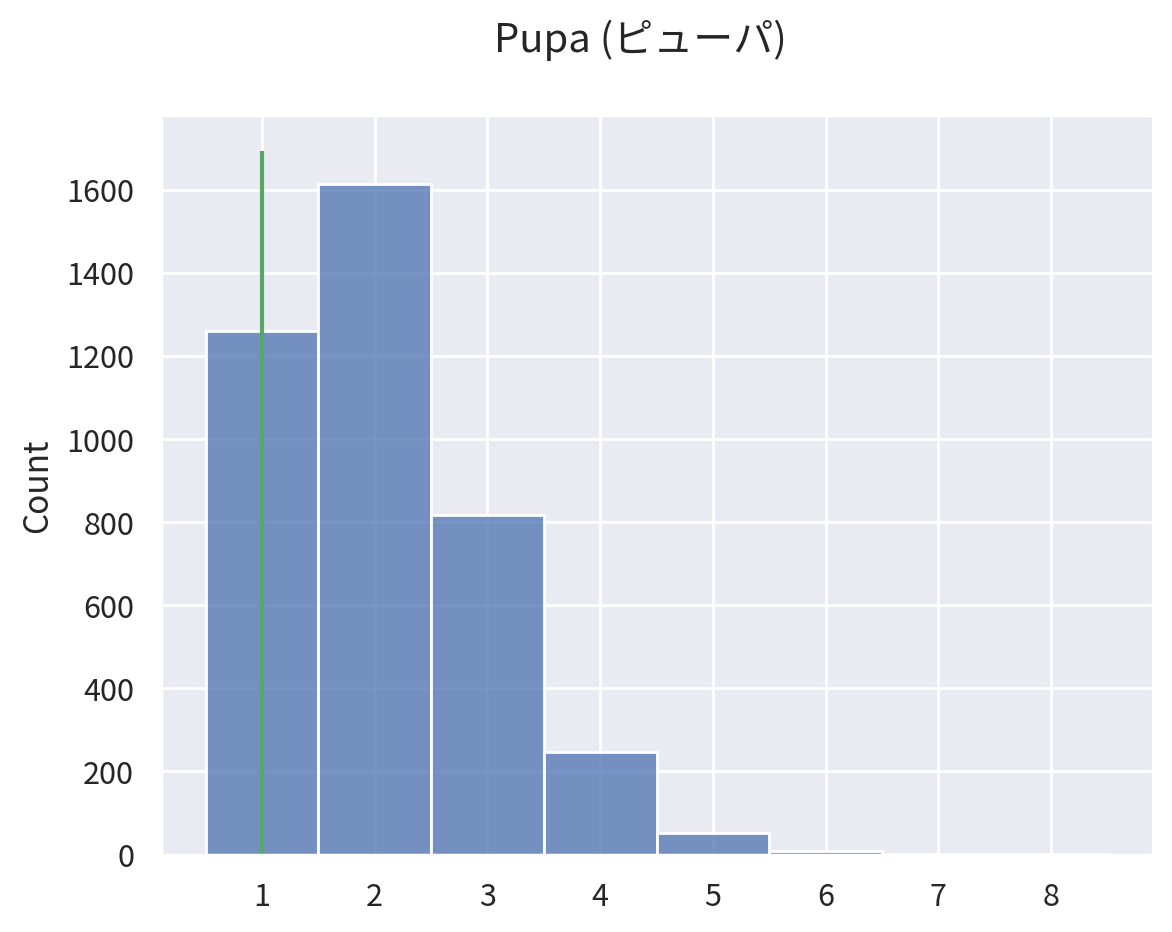

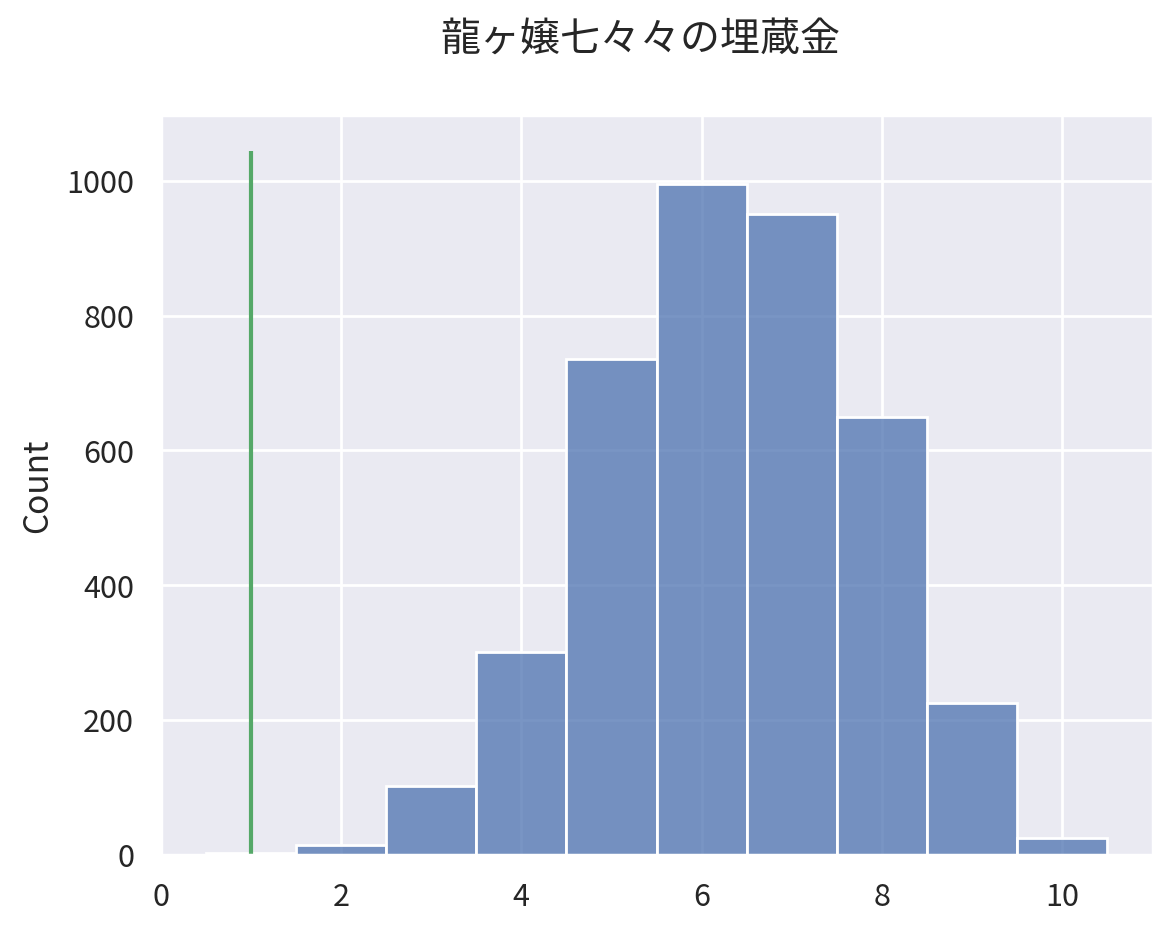

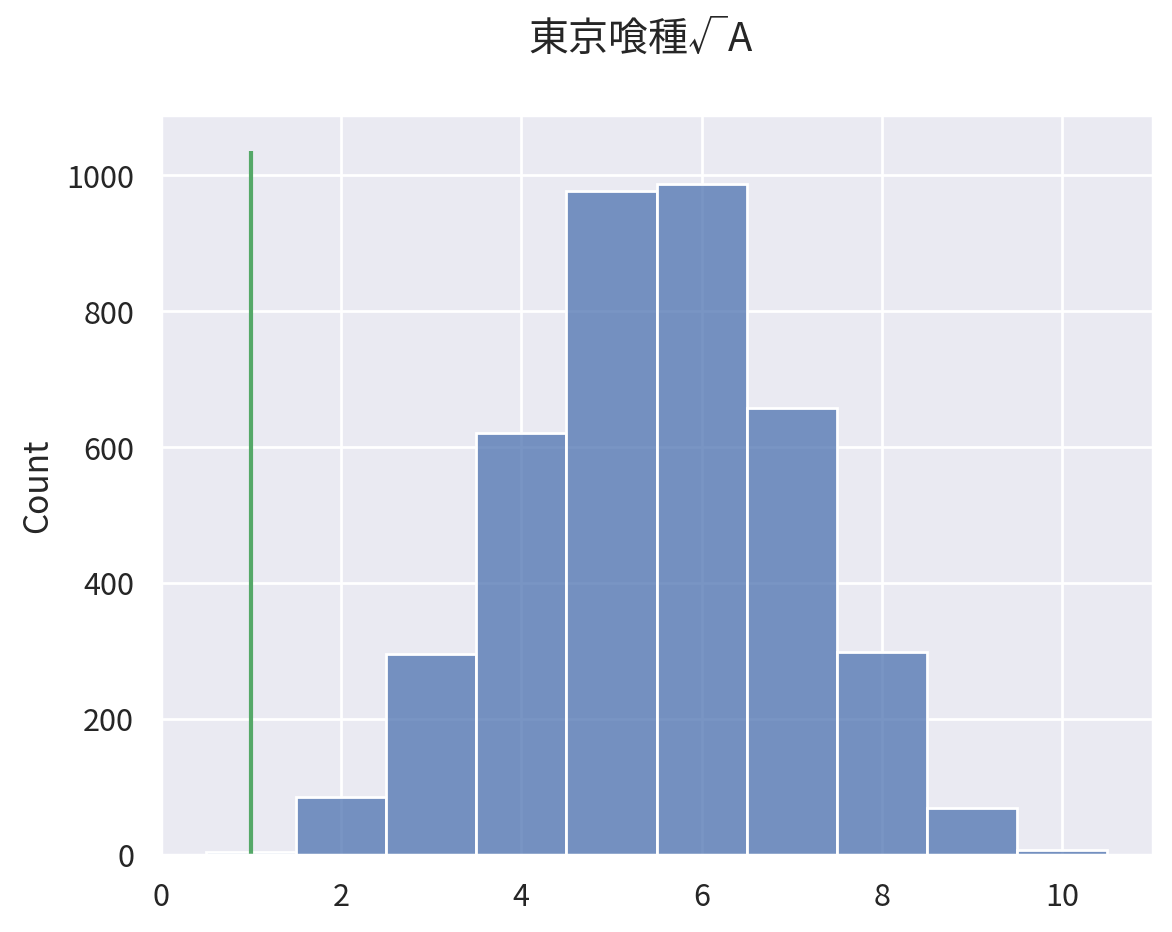

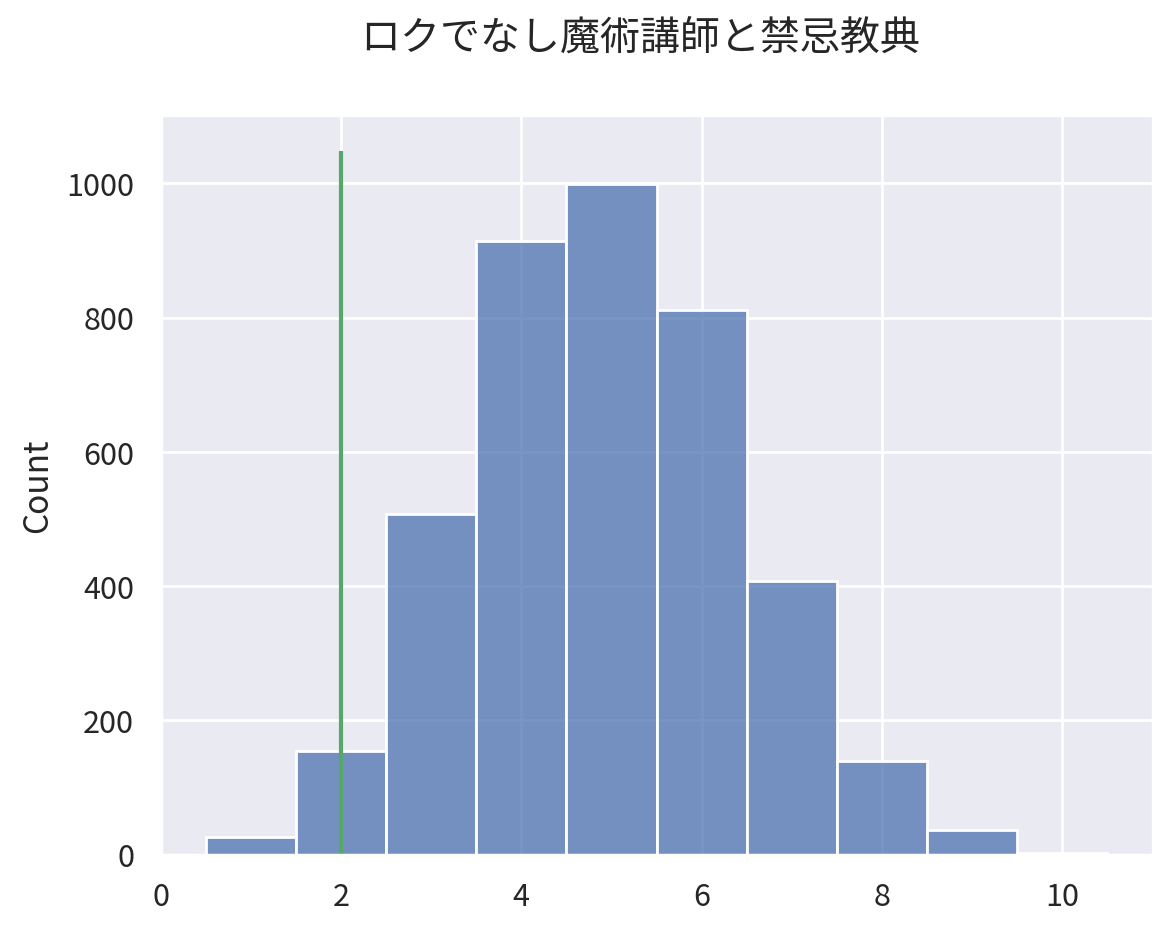

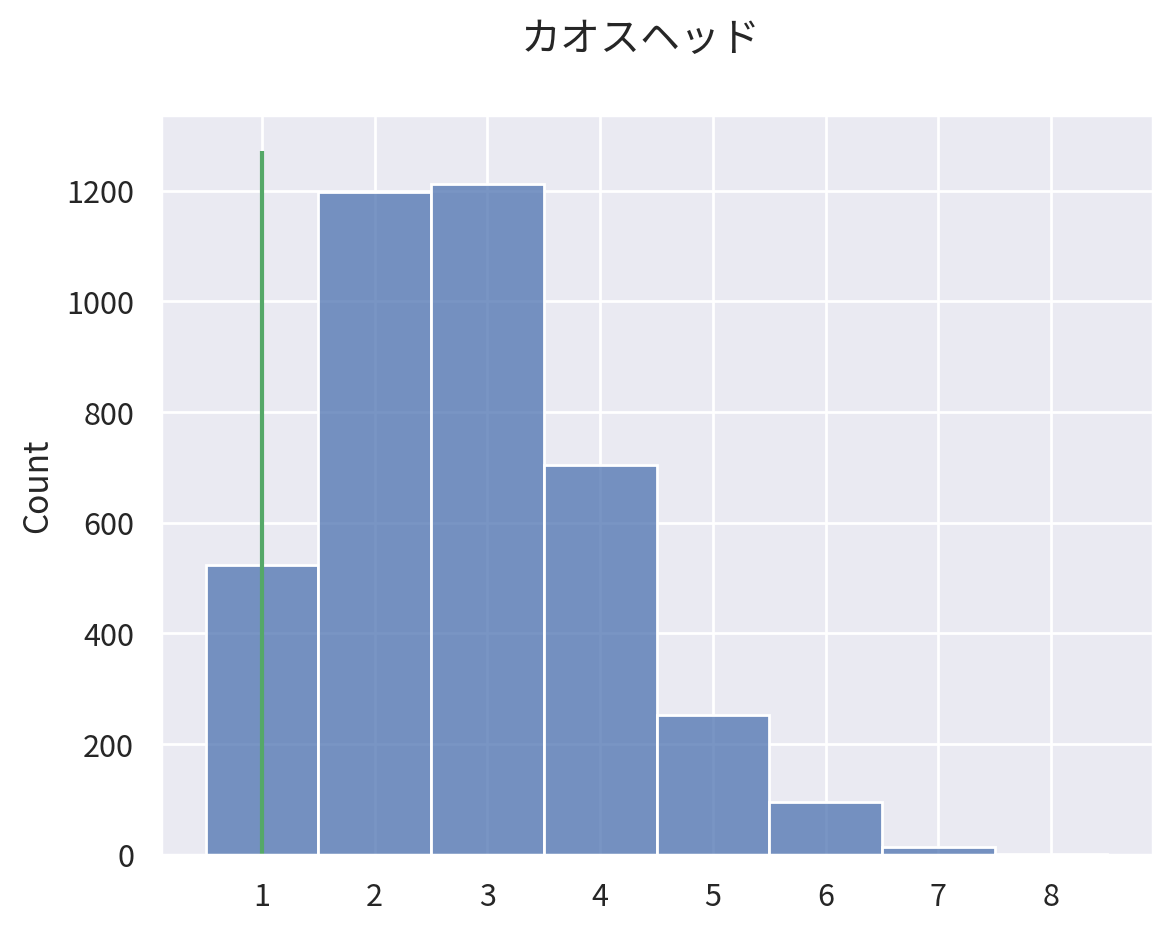

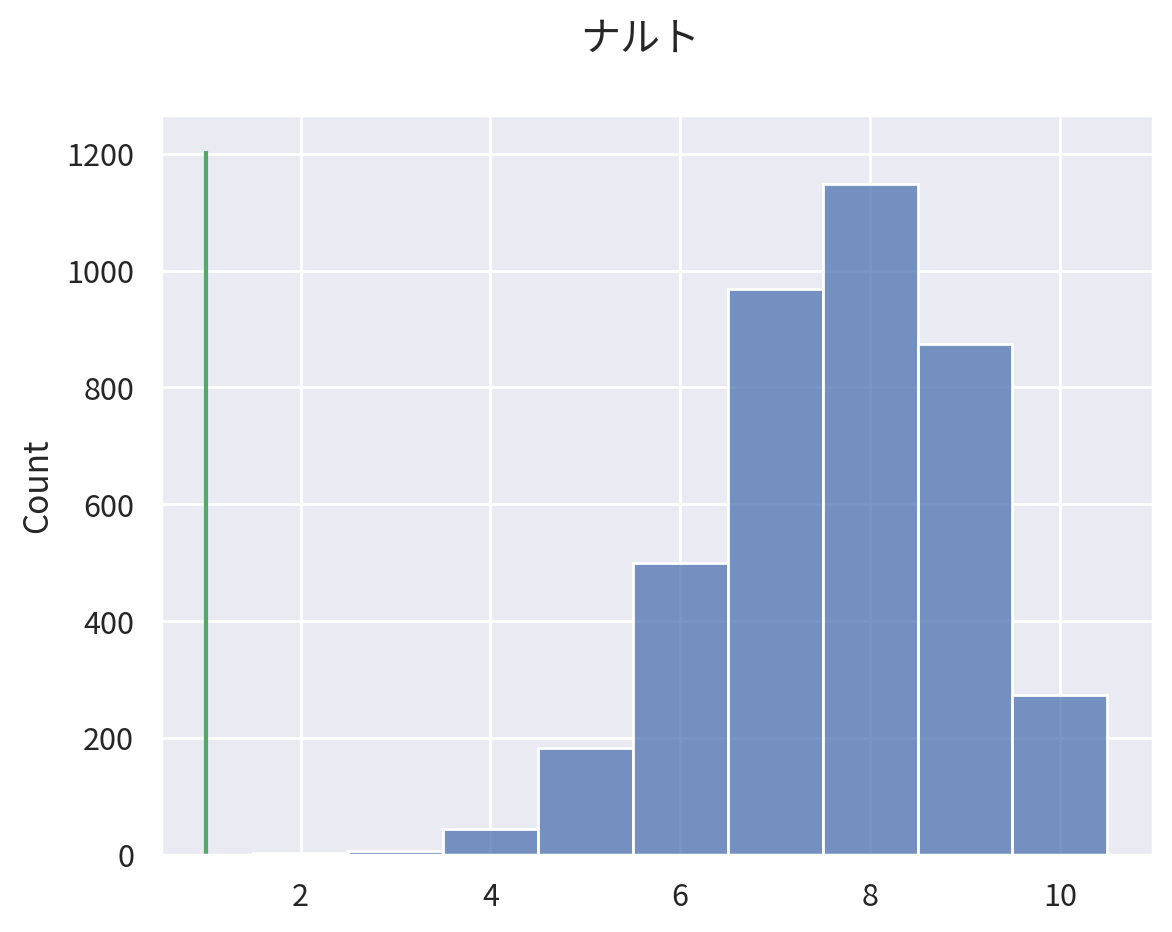

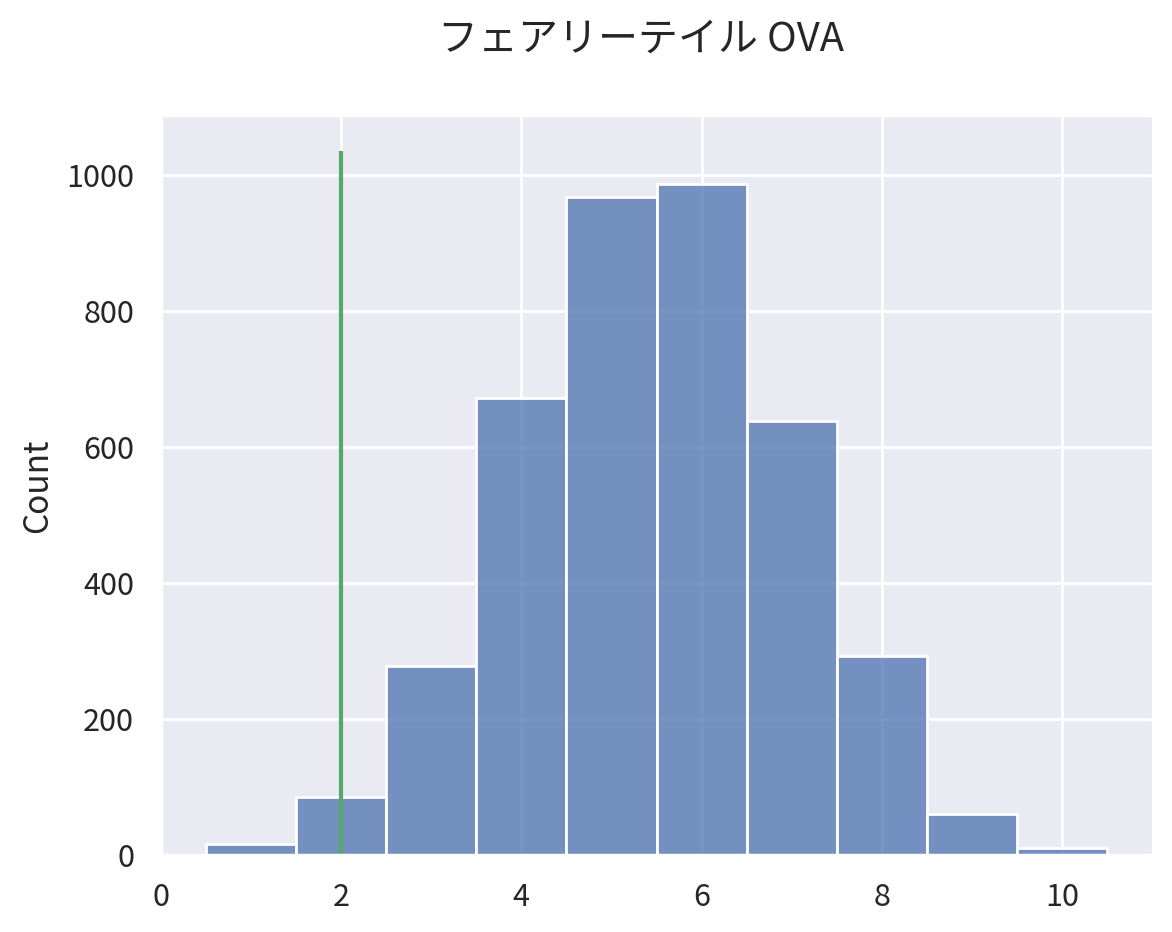

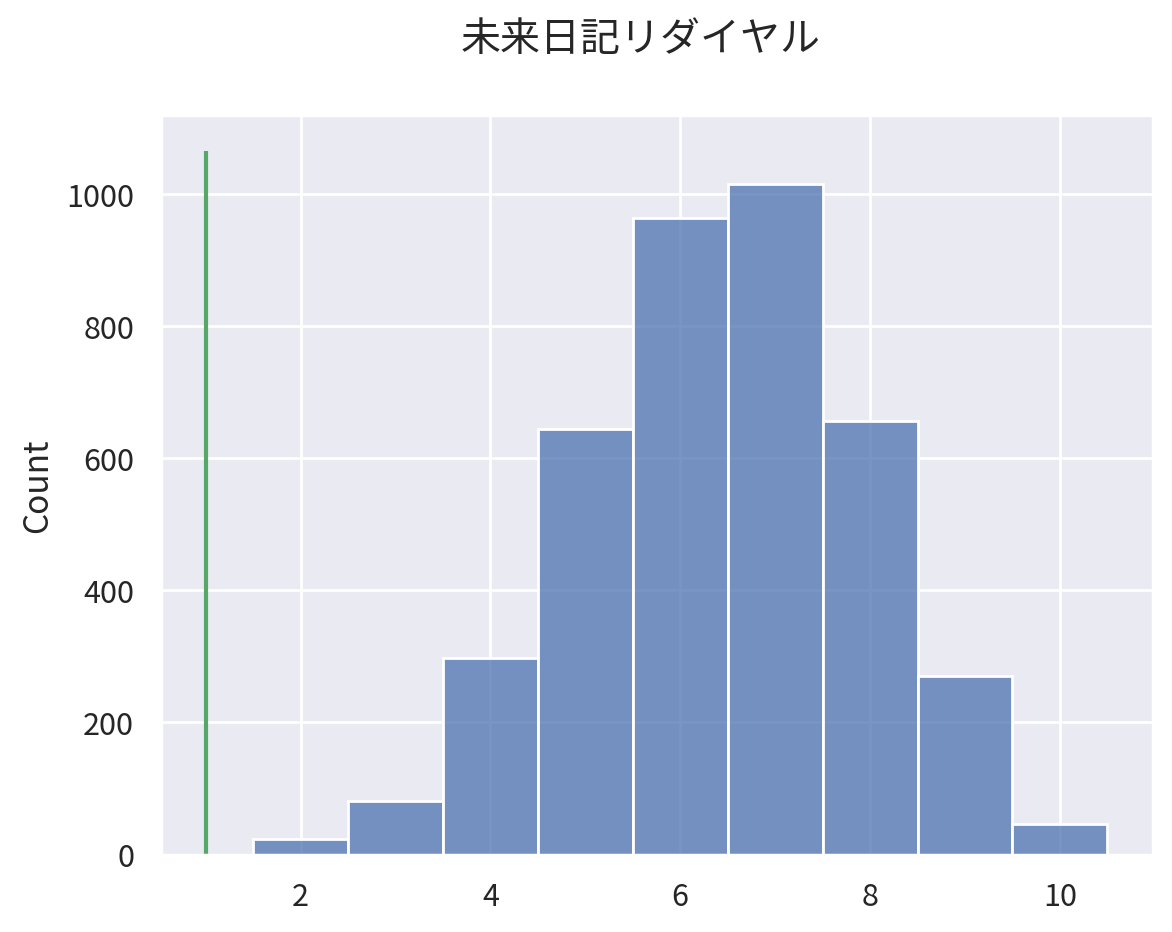

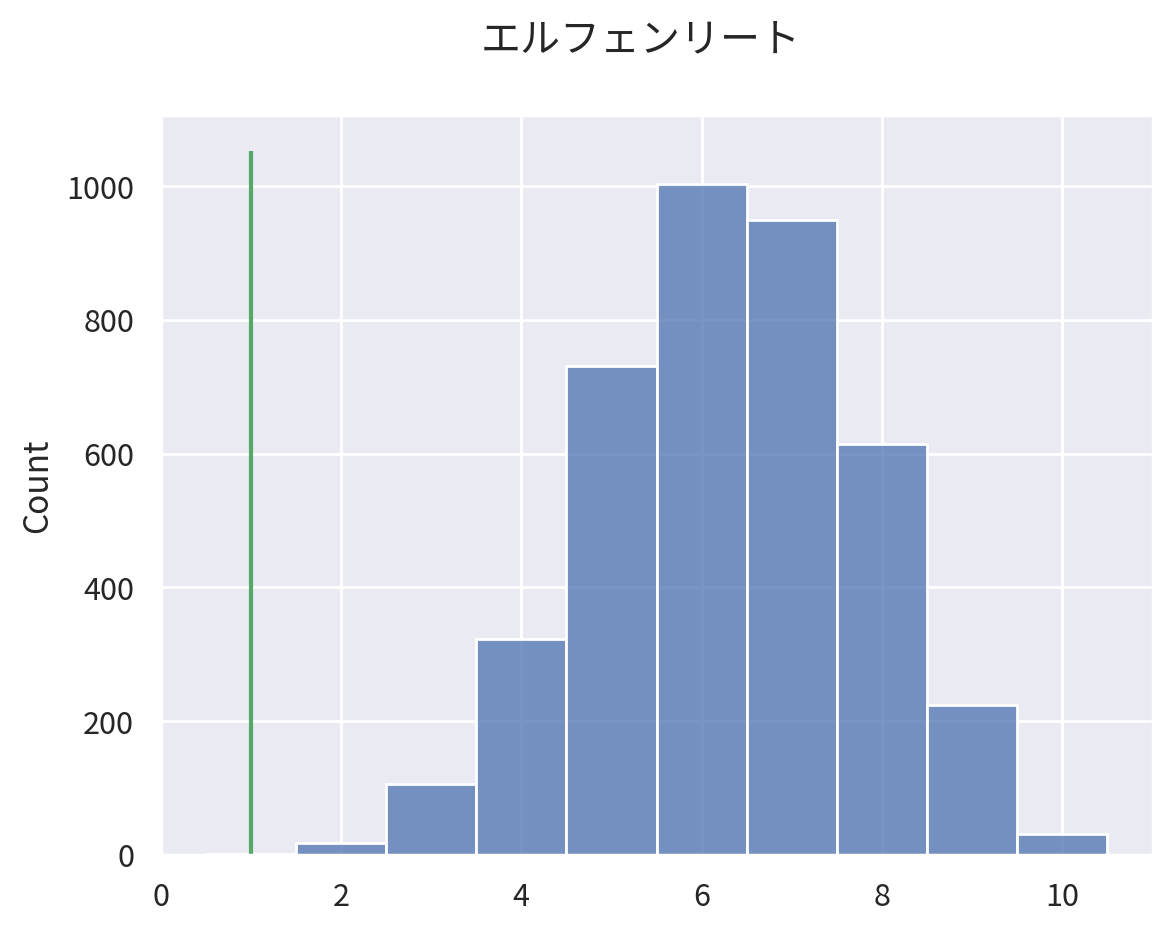

In [58]:
low_scores = df_train.query("score < 3").index.to_numpy()
np.random.shuffle(low_scores)

for i, ind in enumerate(low_scores):
    score = df_train.iloc[ind, :].score
    anime_id = df_train.iloc[ind, :].anime_id

    anime_info = df_anime.query("anime_id == @anime_id")
    anime_name = anime_info.japanese_name.item()

    samples = y_train_pred[ind] + 1
    fig, ax = plt.subplots()
    sns.histplot(x=samples, discrete=True, ax=ax)
    ax.vlines(x=score, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color="C2")
    fig.suptitle(anime_name)
    if i > 10:
        break

あまりにも低スコアを予測するのが難しい。

低スコアを予測するようなMFを作る方が良いか？

In [60]:
df_train.query("score <= 5").pivot_table(index="user_id", columns="anime_id", values="score")

anime_id              00839a3507ab168abe75  0192331235e110fe4f76  \
user_id                                                            
0008e10fb39e55447333                   NaN                   NaN   
001a7aed2546342e2602                   NaN                   NaN   
003d4b0257cc7849ffe1                   NaN                   NaN   
0054e700b5be6e074fb7                   NaN                   NaN   
0059344eed7e8ca0b6c5                   NaN                   NaN   
...                                    ...                   ...   
fdf37675876b15128b77                   NaN                   NaN   
fe23a25ee8f0a7d09d0d                   NaN                   NaN   
fe9c772c995668ea3b75                   NaN                   NaN   
ff5e8e9e3553b90f222a                   NaN                   NaN   
ffa6ff8006f8630f3d11                   NaN                   NaN   

anime_id              019bafd9d5edbf17d2d1  01e4c56439ca58e9c71a  \
user_id                                                            
0008e10fb39e55447333                   NaN                   NaN   
001a7aed2546342e2602                   NaN                   NaN   
003d4b0257cc7849ffe1                   NaN                   NaN   
0054e700b5be6e074fb7                   NaN                   NaN   
0059344eed7e8ca0b6c5                   NaN                   NaN   
...                                    ...                   ...   
fdf37675876b15128b77                   NaN                   NaN   
fe23a25ee8f0a7d09d0d                   NaN                   NaN   
fe9c772c995668ea3b75                   NaN                   NaN   
ff5e8e9e3553b90f222a                   NaN                   NaN   
ffa6ff8006f8630f3d11                   NaN                   NaN   

anime_id              01f07072c8b0314147ec  021a1486338e799af655  \
user_id                                                            
0008e10fb39e55447333                   NaN                   NaN   
001a7aed2546342e2602                   NaN                   NaN   
003d4b0257cc7849ffe1                   NaN                   NaN   
0054e700b5be6e074fb7                   NaN                   NaN   
0059344eed7e8ca0b6c5                   NaN                   NaN   
...                                    ...                   ...   
fdf37675876b15128b77                   NaN                   NaN   
fe23a25ee8f0a7d09d0d                   NaN                   NaN   
fe9c772c995668ea3b75                   NaN                   NaN   
ff5e8e9e3553b90f222a                   NaN                   NaN   
ffa6ff8006f8630f3d11                   NaN                   NaN   

anime_id              02276a56be2c415183a8  023a330255819853e1c0  \
user_id                                                            
0008e10fb39e55447333                   NaN                   NaN   
001a7aed2546342e2602                   NaN                   NaN   
003d4b0257cc7849ffe1                   NaN                   NaN   
0054e700b5be6e074fb7                   NaN                   NaN   
0059344eed7e8ca0b6c5                   NaN                   NaN   
...                                    ...                   ...   
fdf37675876b15128b77                   NaN                   NaN   
fe23a25ee8f0a7d09d0d                   NaN                   NaN   
fe9c772c995668ea3b75                   NaN                   NaN   
ff5e8e9e3553b90f222a                   NaN                   NaN   
ffa6ff8006f8630f3d11                   NaN                   NaN   

anime_id              02abab203e8b3ff9b5a3  02b8f21718b94b4429e2  \
user_id                                                            
0008e10fb39e55447333                   NaN                   NaN   
001a7aed2546342e2602                   NaN                   NaN   
003d4b0257cc7849ffe1                   NaN                   NaN   
0054e700b5be6e074fb7                   NaN                   NaN   
0059344eed7e8ca0b6c5                   NaN          

In [61]:
idata.to_netcdf("../model/train_full_idata.nc")

'../model/train_full_idata.nc'